# Trabalho de Redes Complexas

**ALUNA:**: Ana Carolina Wagner Gouveia de Barros


**PROFESSOR**: Moacyr Silva


**Mestrado em Modelagem Matemática - EMAp|FGV - 2019.2**


Fontes: 

[Chapter 4 - The Scale-Free Property](http://networksciencebook.com/chapter/4)

[Chapter 10 - Spreading Fenomena](http://networksciencebook.com/chapter/10)

[Artigo do Bollobás](https://github.com/anacwagner/FGV_EMAp_Mestrado/blob/master/Redes-Complexas-2019/Bibliografia/Bollobás%20-%20Mathematical%20results%20on%20scale-free%20random%20graphs.pdf)

In [1]:
# Bibliotecas importadas
import networkx as nx

import numpy as np
import random as rnd
rnd.seed()

import csv
import pickle
import itertools

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

**Observação**: Alguns comandos foram comentados para não ocorrer incompatibilidade com visualização armazenada e, consequentemente, com as medidas calculadas. Além disso, pelo fato de alguns algoritmos demorarem um pouco para serem executados, algumas variáveis foram salvas em pickles (formato '.p' e encontram-se na pasta [Redes](https://github.com/anacwagner/FGV_EMAp_Mestrado/tree/master/Redes-Complexas-2019/Redes). Portanto, caso queira obter novos resultados, as linhas comentadas devem ser analisadas. 

## I. Geração de Redes

### EXERCÍCO 1:

Construa um programa que gere uma rede a partir de uma distribuição dada – “configuration model” ou modelo de pareamento. Para simplificar, pode permitir *autoloops* e arestas repetidas.

**Entrada:** número de vértices $N$, grau de cada nó.

**Saída:** lista de arestas.

O **modelo de configuração** cria uma rede com uma sequência de graus predefinida (pode ser qualquer uma). O algoritmo começa a partir de uma distribuição de grau inicialmente especificada $p_k$ (fração de vértices na rede que tem grau $k$), em que atribuímos a cada nó $i$ um grau $k_i$ de acordo com uma certa distribuição. Vale ressaltar que o grau total da rede deve ser par, caso contrário teremos nós desemparelhados. 

*Fonte da Figura*: http://networksciencebook.com/chapter/4#generating-networks

<img src="Figuras/configurationmodel_barabasi.jpg" alt="drawing" width="300"/>


* Começamos selecionando um par de vértices aleatoriamente e ligamos eles. 


* A cada etapa que selcionamos, diminuímos duas unidades da quantidade de grau total da rede e repetimos este processo até que não tenha mais nenhum grau remanescente.

Aplicando repetidamente esse procedimento na mesma sequência de graus, podemos gerar redes diferentes com o mesmo $p_k$, algumas possuem ciclos, auto-loops ou até mesmo multiligações. 

**Obs.:** Este modelo, por ter um caráter inerentemente aleatório, ajuda a calcular analiticamente numerosas medidas de rede.

A função `configurationModel` recebe como **parâmetros de entrada** o número de vértices $N$ e um dicíonário *degree_dist*, formado pelos vértices e seus respectivos graus, e gera como **saída** uma lista de arestas, *edges*, com todas as ligações formadas a partir do pareamento.

In [2]:
def configurationModel(N,degree_dist):
    
    edges = []
    nodes = list(range(1,N+1))
    
    degrees = list(degree_dist.values())
    degree_total = sum(list(degree_dist.values()))
    
    while degree_total > 0:
        node_i = rnd.choice(nodes)
        degree_dist[node_i] -= 1
        if degree_dist[node_i] == 0:
            nodes.remove(node_i)
         
        node_j = rnd.choice(nodes)
        degree_dist[node_j] -= 1
        if degree_dist[node_j] == 0:
            nodes.remove(node_j)
 
        degree_total = degree_total - 2
 
        edges.append([node_i, node_j])
 
    return edges

### EXERCÍCIO 2:

Gere redes livres de escala com $1.000$ vértices a partir do modelo de pareamento com as seguintes combinações de parâmetros: $\alpha = 2.5$ e $\left \langle k \right \rangle = 1$, $\left \langle k \right \rangle=2$ e $\left \langle k \right \rangle=10$.

Com o algoritmo criado no **Exercício 1**, vamos usar a **distribuição de pareto** para gerar a distribuição dos graus. 

$$F(x)=1-\left(\frac{x_{m}}{x}\right)^{\alpha+1}$$

Para cada nó $i$ é gerado um número aleatório $y$ e calculamos $F^{-1}(x)$, dada por

$$F^{-1}(x)=x_{m}(1-y)^{-1/\alpha+1}$$

O valor do grau mínimo $x_m$ é calculado em função do grau médio $\left\langle k\right\rangle$ , em que $x_{m}=\left\langle k\right\rangle \left(\frac{\alpha}{\alpha+1}\right)$. 

A função `degreeDistributionPareto`  recebe como **parâmetros de entrada** o número de vértices $N$, o expoente $\alpha$ e o grau médio  $\left\langle k\right\rangle$ e gera como **saída** um dicionário com os vértices e seus respectivos graus de acordo com a distribuição prede􏰀finida. 



In [3]:
def degreeDistributionPareto(N, alpha, k):
    
    nodes = []
    degree_total = 0
 
    # Grau Minimo
    xm = k * (alpha / (alpha + 1))
    
    for i in range(1, N + 1):
        degree = 0
        while degree == 0: 
            y = rnd.random()
            inversa = xm * ((1 - y) ** (1/ (-alpha + 1))) 
            degree = int(inversa)
 
        degree_total = degree_total + degree
        nodes.append([i, degree])
        
    if (degree_total % 2) != 0:
        nodes[0][1] = nodes[0][1] + 1
 
    nodes_dict = {node[0]: (node[1]) for node in nodes}
    return nodes_dict

Vamos usar o algoritmo criado, `degreeDistributionPareto`, para gerar as redes a partir da distribuição de pareto.

In [4]:
# Parâmetros do modelo
N=1000
alpha=2.5

In [5]:
G1 = degreeDistributionPareto(N, alpha, 1)
G2 = degreeDistributionPareto(N, alpha, 2)
G3 = degreeDistributionPareto(N, alpha, 10)

Agora, vamos usar o algoritmo `configurationModel` para gerar **redes livres de escala** a partir do modelo de paramento, em que o grau $k$ de cada nó $i$ é extraído a partir de uma **distribuição de pareto**. Com $N = 1.000$ geramos três redes usando esse algoritmo: **SF1**, **SF2** e **SF3**. 

In [6]:
#SF1 = configurationModel(N, G1)
#SF2 = configurationModel(N, G2)
#SF3 = configurationModel(N, G3)

#pickle.dump([SF1,SF2,SF3], open("Redes/Pareamento_SF.p", "wb"))
[SF1,SF2,SF3] = pickle.load(open("Redes/Pareamento_SF.p", "rb" ))

In [7]:
def write_csv(G,name):
    length = len(G)
    with open("Redes/Pareamento_%s.csv" %(name), "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Source', 'Target'])
        for i in range(length):
            csv_writer.writerow(G[i])

#write_csv(SF1,"SF1")
#write_csv(SF2,"SF2")
#write_csv(SF3,"SF3")

### EXERCÍCIO 3:

Visualize as redes e encontre o grau máximo e o diâmetro. Calcule a variância de $\left \langle k \right \rangle$ e a distribuição dos graus de entrada. Mostre como determinar o grau máximo esperado e o diâmetro esperado de cada rede. Compare os valores encontrados com os esperados.

A função `degree_distribution` recebe como **parâmetro de entrada** uma rede G (obtido pela biblioteca *networkx* a partir de uma lista de arestas) e o tipo do grau $k$ (entrada, saída ou total). Ela calcula a distribuição dos graus, gerando duas **saídas**: uma lista com todos os graus $k$ e outra lista correspondente as suas respectivas probabilidades $P(k)$. 

In [8]:
def degree_distribution(G, k_type='tot'):
    if k_type == 'in':
        degrees = list(dict(G.in_degree()).values())
    elif k_type == 'out':
        degrees = list(dict(G.out_degree()).values())
    elif k_type == 'tot':
        degrees = list(dict(G.degree()).values())
        
    max_degree = max(degrees)
    kvalues = np.arange(0,max_degree+1)
    Pk = np.zeros(max_degree+1) 
    for k in degrees:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # A soma dos elementos de P(k) deve ser igual a 1
    
    return kvalues,Pk

A função `plot_in_degree_distribution` gera os **gráficos da distribuição dos graus de entrada**. Ela recebe dois **parâmetros de entrada**: o grafo G (obtido pela biblioteca *networkx* a partir de uma lista de arestas) e o nome da rede a ser utilizado no título dos gráficos.

In [9]:
def plot_degree_distribution(G, name):
    
    k,Pk = degree_distribution(G)
    # Remove as ocorrências de grau zero 
    k=k[1:]
    Pk=Pk[1:]
    print(k)
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(k, Pk, "o", color = "purple")
    plt.xlabel('$k$', fontsize=16)
    plt.ylabel('$p_k$', fontsize=16)
    plt.title('Degree Distribution - %s' %(name), fontsize=20)
    plt.grid()
    
    plt.subplot(122)
    #plt.loglog(k, Pk, 'p', marker='o', color = "purple")
    degree_sequence=sorted(dict(G.degree).values(),reverse=True)
    x = list(np.linspace(1,max(degree_sequence),len(degree_sequence)))
    plt.loglog(x, degree_sequence, 'p',  marker='o', color = "purple")
    
    plt.xlabel('Degree', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title('Degree Distribution (Log-Log) - %s' %(name), fontsize=18)
    
    plt.show()

Um **caminho** é uma rota que percorre os links da rede. O comprimento de um caminho representa o número de arestas contidas nele. 

A função `diameter` calcula o diâmetro de uma rede, que é definido como o mais longo de todos os caminhos mais curtos calculados em uma rede. Ou seja, é a maior distância registrada entre qualquer par de nós.

In [10]:
def diameter(G):
    max_path = 0
    all_shortest_path = nx.shortest_path(G)
    for node in all_shortest_path.values():
        paths = node.values()
        for p in paths:
            l = len(p)
            if l > max_path:
                max_path = l
                
    # Diâmetro da maior componente conexa
    #return nx.diameter(max(nx.connected_component_subgraphs(G), key=len))
    return max_path - 1

O **$m$-ésimo momento da distribuição de grau** é definido como:

$$\left \langle k^m \right \rangle = \sum_{k_{min}}^{\infty}{k^m\cdot p_k} \approx \int_{k_{min}}^{\infty}{k^m\cdot p(k)dk}$$

A função `momment_of_degree_distribution` calcula o $m$-ésimo momento da distribuição de grau. Ela recebe dois **parâmetros de entrada**: a rede $G$ e um número $m$ correspondente ao momento da distribuição a ser calculado. Esta função é uma auxiliar para calcular a variância de $\left \langle k \right \rangle$ pedida no enunciado da questão.

$$Var(\left \langle k \right \rangle)= \left \langle k^2 \right \rangle - \left \langle k \right \rangle^2$$

In [11]:
def momment_of_degree_distribution(G,m,k_type='tot'): 
    k,Pk = degree_distribution(G,k_type)
    M = sum((k**m)*Pk)
    return M

Inicialmente vamos visualizar as redes obtidas no exercício anterior utilizando o [Gephi](https://gephi.org). Nas figuras, as cores e tamanhos do nós foram ranqueados pelo seu respectivo grau de entrada. Além disso, as arestas possuem as cores dos nós de entrada e sua espessura está relacionada ao número de ligações existentes entre os nós $i$ e $j$. 

#### REDE 1: 
A figura mostra a rede gerada **SF1**, com $\left\langle k\right\rangle = 1$ e $\alpha = 2,5$.
<img src="Figuras/SF1.png" alt="drawing" width="500"/>

In [12]:
# A partir da lista de arestas SF1, podemos construir a rede V1 correspondente
V1 = nx.Graph(SF1)
print(nx.info(V1))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 1164
Average degree:   2.3280


In [13]:
print('Grau Máximo: ' + str(max(list(dict(V1.degree()).values()))))

Grau Máximo: 27


In [14]:
print('Diâmetro da rede: ' + str(diameter(V1))) # usa a função calculada anteriormente

Diâmetro da rede: 15


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


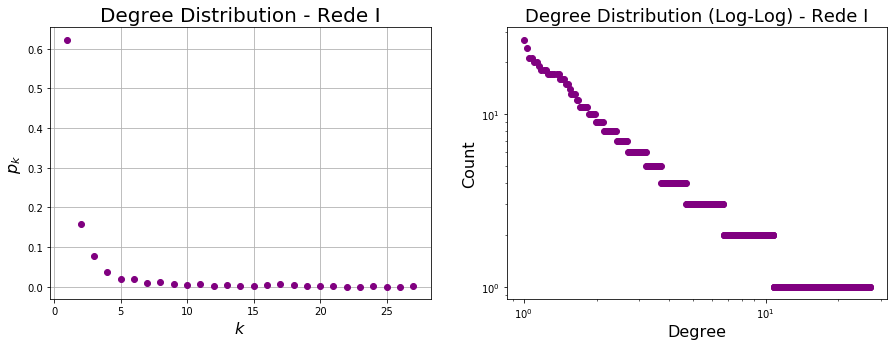

In [15]:
# Distribuição dos graus de entrada
plot_degree_distribution(V1,'Rede I')

In [16]:
# O primeiro momento é igual ao grau médio da rede
m1 = momment_of_degree_distribution(V1,1)
vk = list(dict(V1.degree()).values())
print("Grau Médio = ", np.mean(vk))
print("Primeiro momento da distribuição de grau = ", m1)
print('\n')

# Variância de <k>
m2 = momment_of_degree_distribution(V1,2)
print("Segundo momento da distribuição de grau = ", m2)
print('\n')
variance = round(m2 - m1**2,2)
print("Variância de <k> = ", variance)

Grau Médio =  2.328
Primeiro momento da distribuição de grau =  2.328


Segundo momento da distribuição de grau =  14.92


Variância de <k> =  9.5


#### REDE 2: 
A figura mostra a rede gerada **SF2**, com $\left\langle k\right\rangle = 2$ e $\alpha = 2.5$.
<img src="Figuras/SF2.png" alt="drawing" width="500"/>

In [17]:
# A partir da lista de arestas SF2, podemos construir a rede V2 correspondente
V2 = nx.Graph(SF2) 
print(nx.info(V2))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 1605
Average degree:   3.2100


In [18]:
print('Grau Máximo: ' + str(max(list(dict(V2.degree()).values()))))

Grau Máximo: 37


In [19]:
print('Diâmetro da rede: ' + str(diameter(V2)))

Diâmetro da rede: 16


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]


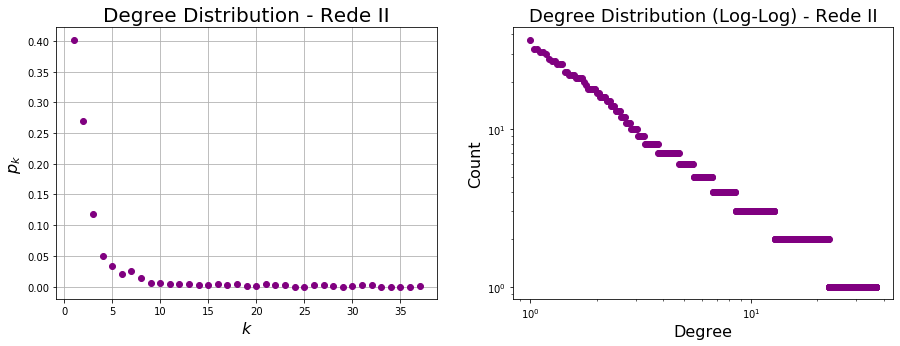

In [20]:
# Distribuição dos graus de entrada
plot_degree_distribution(V2,'Rede II')

In [21]:
# O primeiro momento é igual ao grau médio da rede
m1 = momment_of_degree_distribution(V2,1)
vk = list(dict(V2.degree()).values())
print("Grau Médio = ", np.mean(vk))
print("Primeiro momento da distribuição de grau = ", m1)
print('\n')

# Variância de <k>
m2 = momment_of_degree_distribution(V2,2)
print("Segundo momento da distribuição de grau = ", m2)
print('\n')
variance = round(m2 - m1**2,2)
print("Variância de <k> = ", variance)

Grau Médio =  3.21
Primeiro momento da distribuição de grau =  3.2099999999999986


Segundo momento da distribuição de grau =  29.979999999999997


Variância de <k> =  19.68


#### REDE 3: 
A figura mostra a rede gerada **SF3**, com $\left\langle k\right\rangle = 10$ e $\alpha = 2,5$.
<img src="Figuras/SF3.png" alt="drawing" width="500"/>

In [22]:
# A partir da lista de arestas SF3, podemos construir a rede V3 correspondente
V3 = nx.Graph(SF3) # Rede direcionada
print(nx.info(V3))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 8135
Average degree:  16.2700


In [23]:
print('Grau Máximo: ' + str(max(list(dict(V3.degree()).values()))))

Grau Máximo: 85


In [24]:
print('Diâmetro da rede: ' + str(diameter(V3)))

Diâmetro da rede: 5


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]


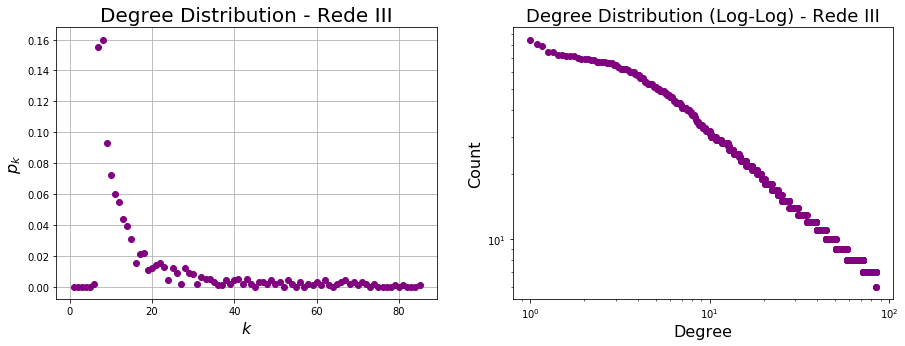

In [25]:
# Distribuição dos graus de entrada
plot_degree_distribution(V3,'Rede III')

In [26]:
# O primeiro momento é igual ao grau médio da rede
m1 = momment_of_degree_distribution(V3,1)
vk = list(dict(V3.degree()).values())
print("Grau Médio = ", np.mean(vk))
print("Primeiro momento da distribuição de grau = ", m1)
print('\n')

# Variância de <k>
m2 = momment_of_degree_distribution(V3,2)
print("Segundo momento da distribuição de grau = ", m2)
print('\n')
variance = round(m2 - m1**2,2)
print("Variância de <k> = ", variance)

Grau Médio =  16.27
Primeiro momento da distribuição de grau =  16.27


Segundo momento da distribuição de grau =  458.332


Variância de <k> =  193.62


A tabela a seguir mostra o resumos das medidas calculadas para cada uma dessas redes apresentadas.

|   Redes  	| Arestas 	| Var($\left\langle k\right\rangle$) 	| $k_{max}$ 	| Diâmetro 	| Componentes Conexas 	|
|:--------:	|---------	|:----------------------------------:	|:---------:	|:--------:	|:-------------------:	|
|  Rede I  	|   1190  	|                  9.5               	|     37    	|    16    	|         175         	|
|  Rede II 	|   1651  	|                19.68                	|     27    	|    15    	|          76         	|
| Rede III 	|   8503  	|               193.62               	|     85    	|     5    	|           1          	|

O **grau máximo esperado** é dado por:

$$k_{max} \sim k_{min} \cdot N^{\frac{1}{\alpha-1}}$$

In [27]:
def expected_max_degree(G, alpha=2.5):
    GC = max(nx.connected_component_subgraphs(G), key=len)
    N = len(GC.nodes())
    kmin = min(list(dict(GC.degree()).values()))
    kmax = kmin*(N**(1/(alpha-1)))
    return kmax

In [28]:
print('O grau máximo esperado para a Rede I é ' + str(expected_max_degree(V1)))
print('O grau máximo esperado para a Rede II é ' + str(expected_max_degree(V2)))
print('O grau máximo esperado para a Rede III é ' + str(expected_max_degree(V3)))

O grau máximo esperado para a Rede I é 70.66281969485719
O grau máximo esperado para a Rede II é 88.1766424335092
O grau máximo esperado para a Rede III é 599.9999999999998


O **diâmetro esperado** é dado por

$$d ~ \sim \ln\ln N$$

In [29]:
def expected_diameter(G, alpha=2.5):
    GC = max(nx.connected_component_subgraphs(G), key=len)
    N = len(G.nodes())
    d = np.log(np.log(N))
    return d

In [30]:
print('O diâmetro esperado para a Rede I é ' + str(expected_diameter(V1)))
print('O diâmetro esperado para a Rede II é ' + str(expected_diameter(V2)))
print('O diâmetro esperado para a Rede III é ' + str(expected_diameter(V3)))

O diâmetro esperado para a Rede I é 1.9326447339160655
O diâmetro esperado para a Rede II é 1.9326447339160655
O diâmetro esperado para a Rede III é 1.9326447339160655


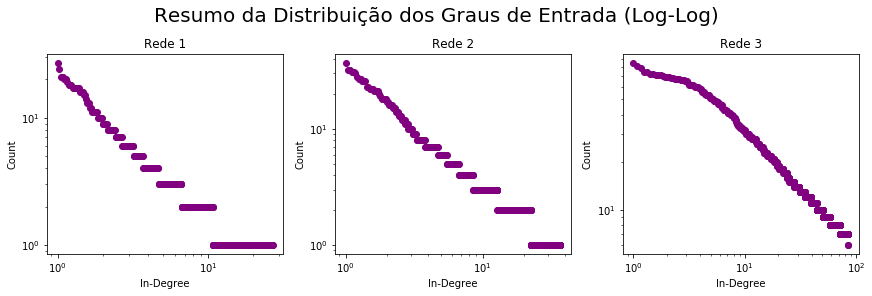

In [31]:
fig, axs = plt.subplots(1,3, figsize=(12, 4), constrained_layout=True)
fig.suptitle('Resumo da Distribuição dos Graus de Entrada (Log-Log)', fontsize=20)
V = [V1, V2 ,V3]
axs = axs.ravel()
for i in range(3):
    degree_sequence=sorted(dict(V[i].degree).values(),reverse=True) 
    x = list(np.linspace(1,max(degree_sequence),len(degree_sequence)))
    axs[i].loglog(x, degree_sequence, 'p',  marker='o', color = "purple")
    axs[i].set_title('Rede ' + str(i+1))
    axs[i].set_xlabel('In-Degree')
    axs[i].set_ylabel('Count')

Para uma rede livre de escala o $m$-ésimo momento da distribuição de grau é

$$\left \langle k^m \right \rangle  = \approx \int_{k_{min}}^{\infty}{k^m\cdot p(k)dk} = C \frac{k_{max}^{m-\alpha+1}-k_{min}^{m-\alpha+1}}{m-\alpha+1}$$

Enquanto $k_{min}$ é praticamente fixo, o grau do maior hub, $k_{max}$, aumenta com o tamanho do sistema. Ou seja, quando $k_{max} \rightarrow \infty$:

* Se $(m-\alpha+1) \leq 0$, então $k_{max}^{m-\alpha+1} \rightarrow 0$. Portanto, todos os momentos que satisfazem $m \leq \alpha − 1$ são finitos.


* Se $(m-\alpha+1) \geq 0$, então $\left \langle k^m \right \rangle \rightarrow \infty$. Portanto,todos os momentos que satisfazem $m > \alpha -1$ divergem.


Para as redes analizadas, temos $\alpha=2.5$. Então, é esperado que os momentos $m>1$ divirjam. 

## II. Simulação de Epidemias

No **modelo SIS**, os indivíduos infectados não são imunes às doenças podendo, mesmo após a recuperação, serem infectados novamente. Há apenas dois estados (modelo compartimental): **suscetíveis** (S) e **infectados** (I), em que esses últimos tornam-se suscetíveis após a recuperação.

Um indivíduo no estado suscetível não possui a doença, mas pode pegá-la caso entre em contato com algum indíviduo no estado infectado, aquele que possui a doença e pode transmití-la (mistura homogênea). Vamos considerar uma doença que se espalha através de uma população de indivíduos. Seja $S(t)$ o número de indivíduos que são suscetíveis no tempo $t$ e $I(t)$ o número de indivíduos que estão infectados. Como nesse modelo um indivíduo só possui duas opções de estados, temos que $S + I = N$, onde $N$ é a população total. O conjunto de equações que descrevem a dinâmica desse modelo é dada pelas seguintes equações diferenciais:

$$\frac{ds}{dt}=\mu i - \beta \left \langle k \right \rangle i(1-i) \qquad \frac{di}{dt}=\beta \left \langle k \right \rangle i(1-i) - \mu i$$


onde $\beta$ é a probabilidade de a doença ser transmitida de um indivíduo infectado para um indivíduo suscetível (aqueles que são seus vizinhos) em um tempo unitário (**taxa de infecção**) e $\mu$ é a probabilidade de um indivíduo infectado se recuperar da doença em um tempo unitário (**taxa de recuperação**).

O algoritmo descrito na função `SIS`, a seguir, simula o comportamento epidêmico de uma rede no modelo SIS. Para a construção do model foram adicionados dois atributos aos nós: 'infectado' e 'imunizado'. 

In [32]:
def SIS(G, beta, mu, time, immunization=False):
    
    N = len(G.nodes())
    nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'infectado')
    
    if immunization == False:
        nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'imunizado')
        nodes_susceptible =  list(range(1,N+1))
    else:
        immune = dict(nx.get_node_attributes(G,'imunizado'))
        values = np.array(list(immune.values()))
        nodes_susceptible = list(np.where(values == False)[0]+1)
    
    print('S = ' + str(len(nodes_susceptible)))
    nodes_infected = rnd.sample(nodes_susceptible, 5) # Em t0 temos 5 infectados
     
    for node in nodes_infected:
        G.node[node]['infectado'] = True
    
    historic = [len(nodes_infected)] # Aramzena a quantidade de infectados conforme a evolução do tempo
    
    for t in range(1,time+1):
        
        old_infected = nodes_infected
        nodes_infected = []
 
        for node in old_infected:
            for neighbor in G.neighbors(node): # Para cada vizinho do nó infectado
                
                # Nós que não estão infectados 
                if G.node[neighbor]['infectado'] == False and G.node[neighbor]['imunizado'] == False:
                    if rnd.random() < beta: # Se o aleatório for menor que a taxa de infecção
                        nodes_infected.append(neighbor)
                        G.node[neighbor]['infectado'] = True # o vizinho torna-se infectado
            
            # Nós que estão infectados
            if rnd.random() < mu: # Se o aleatório for menor que a taxa de recuperação,
                G.node[node]['infectado'] = False # o nó infectado torna-se suscetível
            else:
                nodes_infected.append(node) # o nó infectado permanece infectado
                
        historic.append(len(nodes_infected))
        
    return (G, historic)

### EXERCÍCIO 1:

Gere uma rede aleatória com $10.000$ vértices e grau médio $\left \langle k \right \rangle = 20$. Comece com 5 vértices aleatórios infectados e simule a propagação da infecção pelo **modelo SIS** com os parâmetros abaixo e compare com os resultados esperados.

a. $\beta=0.02$ e $\mu=0.1$

b. $\beta=0.02$ e $\mu=0.4$

c. $\beta=0.02$ e $\mu=0.5$
    
Mostre que se $𝑅_0 = \frac{\beta \left \langle k \right \rangle}{\mu} > 1$ então a doença se fixa na rede, no modelo SIS de campo médio.

In [33]:
def RandomGraph(N, k):
    pk = k/(N-1)
    G = []
 
    nodes = range(1,N+1)
    edges = itertools.combinations(nodes,2)
    for e in edges:
        if rnd.random() < pk:
            G.append(list(e))
    return G

In [34]:
N = 10000
#RG = nx.Graph()
#RG.add_edges_from(RandomGraph(N, 20))

In [35]:
beta = 0.02
time = 300
#G1,T1 = SIS(RG, beta, 0.1, time)
#G2,T2 = SIS(RG, beta, 0.4, time)
#G3,T3 = SIS(RG, beta, 0.5, time)

#pickle.dump([RG,G1,T1,G2,T2,G3,T3], open("Redes/SIS_Random.p", "wb"))
[RG,G1,T1,G2,T2,G3,T3] = pickle.load(open("Redes/SIS_Random.p", "rb" ))

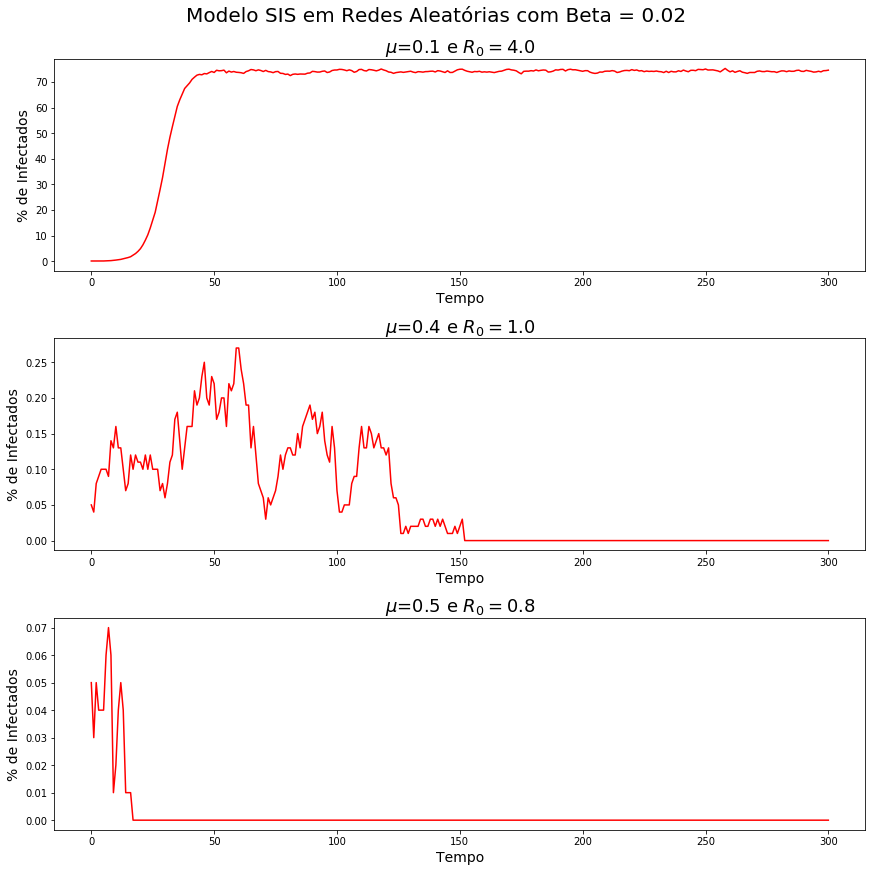

In [36]:
fig, axs = plt.subplots(3,1, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Modelo SIS em Redes Aleatórias com Beta = 0.02', fontsize=20)
T = [T1,T2,T3]
mu = [0.1,0.4,0.5]
#axs = axs.ravel()
for i in range(3):
    ro = beta*20/mu[i]
    axs[i].plot([j/N*100 for j in T[i]], color = "red")
    axs[i].set_title("$\mu$=" + str(mu[i]) + ' e $R_0=$' + str(ro), fontsize=18)
    axs[i].set_xlabel('Tempo', fontsize=14)
    axs[i].set_ylabel('% de Infectados', fontsize=14)

Uma forma muito comum de classi􏰀cação dos resultados obtidos por essas simulações é por meio de uma quantidade limite que determina se uma epidemia ocorre ou se a doença simplesmente morre. Essa quantidade é denominada o **número de reprodução básico** ($R$0) e é responsável por mensurar o potencial de transmissão de uma doença.

$$R_0=\frac{\beta \left \langle k \right \rangle}{\mu}$$

Se $R_0 > 1$, então estamos no **estado endêmico** e se $R_0 < 1$, estamos no **estado livre de doença**, em que a doença morre.

Quando $\mu = 0,1$ (**simulação 1**) temos que $R_0 = 4 > 1$ e, portanto, estamos no **estado endêmico** (ou estacionário). Ou seja, para uma baixa taxa de recuperação, o grá􏰀co de simulação segue uma curva logística. Apesar de nem todo mundo fi􏰀car infectado, $i(t)$ quanto $t \rightarrow \infty$ atinge um valor constante menor do que 1. Dessa forma, a qualquer momento, apenas uma fração 􏰀finita da população está infectada.


Quando $\mu = 0,5$ (**simulação 3**) temos que $R_0 = 08 < 1$ e, portanto, estamos no **estado livre de doença**. Ou seja, para uma taxa de recuperação muito grande ($\mu > \beta$), a cada unidade de tempo $t$, o número de indivíduos suscetíveis excede o número de indivíduos recém-infectados, indicando que a infeção inicial vai morrer com o tempo de forma exponencial. 

Quando $\mu = 0,4$ (**simulação 2**) temos que $R_0 = 1 < 1$ e estamos em um ponto crítico em que há a mudança de estado. Nesse ponto cada vez que realizamos a simulação obtemos um comportamento inicial bem diferente, no entanto, sempre indica que a infeção inicial irá morrer com o tempo.

Os resultados obtidos com as simulações para as redes aleatórias ocorreram como esperado. No entanto, dependendo da distribuição dos graus, o espalahamento da infecção se comporta de forma diferente apesar dos valores de $R_0$. 

### EXERCÍCIO 2:

Gere uma rede livre de escala com $10.000$ vértices, grau médio $\left \langle k \right \rangle = 20$ e expoente $\alpha$ entre 2 e 3. Comece com 5 vértices aleatórios infectados e simule a propagação da infecção pelo **modelo SIS** com os parâmetros abaixo e compare com os resultados esperados.

a. $\beta=0.01$ e $\mu=0.1$

b. $\beta=0.01$ e $\mu=0.2$ 

c. $\beta=0.01$ e $\mu=0.3$ 

In [37]:
def ScaleFreeGraph(N, m, alpha):
    # Rede inicial conectada
    n = 3
    G = RandomGraph(n, n*2)
    old_nodes = list(range(1, n + 1))
 
    k0 = (alpha - 2) * m
 
    # Probabilidade de anexacao preferencial
    p = m / (k0 + m)
 
    new_nodes = range(n, N + 1)
 
    for i in new_nodes:
        # Quatidade de arestas do novo no
        kout =  np.random.poisson(m,)
        while kout == 0: 
            kout = np.random.poisson(m,)
 
        for k in range(1, kout + 1):
            if rnd.random() < p:
                # Escolhe com anexacao preferencial
                edge = rnd.choice(G)
                j = edge[1]
                G.append([i,j])
            else:
                # Escolhe com distribuicao uniforme
                j = rnd.choice(old_nodes)
                G.append([i,j])
        old_nodes.append(i)
    return G

In [38]:
N = 10000
#SFG = nx.Graph()
alpha = 2.5
#SFG.add_edges_from(ScaleFreeGraph(N, 20, alpha))

In [39]:
beta = 0.01
time = 300
#G4,T4 = SIS(SFG, beta, 0.1, time)
#G5,T5 = SIS(SFG, beta, 0.2, time)
#G6,T6 = SIS(SFG, beta, 0.3, time)

#pickle.dump([SFG,G4,T4,G5,T5,G6,T6], open("Redes/SIS_ScaleFree.p", "wb"))
[SFG,G4,T4,G5,T5,G6,T6] = pickle.load(open("Redes/SIS_ScaleFree.p", "rb" ))

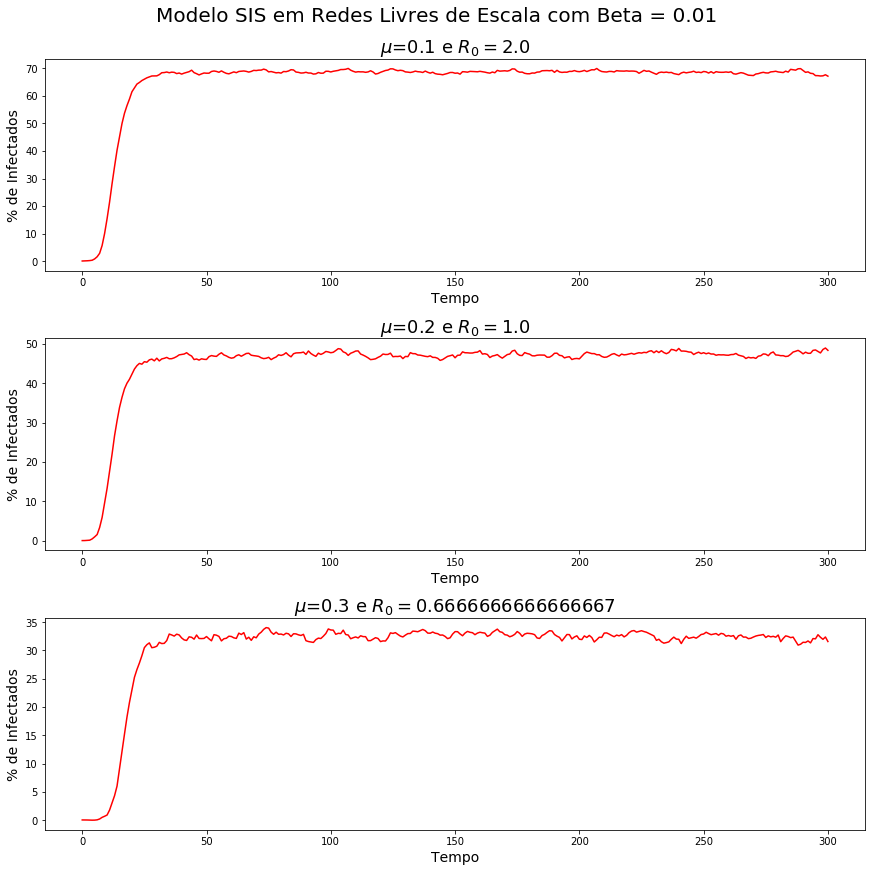

In [40]:
fig, axs = plt.subplots(3,1, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Modelo SIS em Redes Livres de Escala com Beta = 0.01', fontsize=20)
T = [T4,T5,T6]
mu = [0.1,0.2,0.3]
#axs = axs.ravel()
for i in range(3):
    ro = beta*20/mu[i]
    axs[i].plot([j/N*100 for j in T[i]], color = "red")
    axs[i].set_title("$\mu$=" + str(mu[i]) + ' e $R_0=$' + str(ro), fontsize=18)
    axs[i].set_xlabel('Tempo', fontsize=14)
    axs[i].set_ylabel('% de Infectados', fontsize=14)

Assim como 􏰀fizemos no item anterior, vamos determinar o valor de $R_0$ para cada simulação. Quando $\mu = 0.1$ (**simulação 1**) temos que $R_0 = 2 > 1$ e, portanto, deveríamos estar no **estado endêmico** (ou estacionário), o que de fato acontece.

Quando $\mu = 0.3$ (**simulação 3**) temos que $R_0 = 0.8 < 1$ e, portanto, deveríamos estar no estado livre de doença, o que não ocorre.

Essa mudança de comportamento está relacionada a distribuição dos graus dessas redes, que apresentam uma grande variância. Em redes livres de escala, mesmo com um pequeno $\beta$, basta que um hub seja infectado para que boa parte da rede também seja infectada, fazendo com que a doença persista em um estado endêmico. Nessas simulações, à medida que aumentamos o valor de $\mu$, apesar do percentual de indivíduos infectados diminuir, a doença não morre. Isso não aconteu com as simulações feitas anteriomente com redes aleatórias, pois os vértices possuem nós com grau comparável.

### EXERCÍCIO 3:

Considere o exercício anterior, **letra a**. Descubra o número de vértices imunizados necessários para impedir o estado endêmico nos seguintes cenários:

a. Os vértices imunizados são escolhidos aleatoriamente.

b. Os vértices imunizados são os de maior grau (hubs).

c. Os vértices imunizados são os vizinhos de vértices escolhidos aleatoriamente.

Pelo exercício anterior, é possível comprovar que em **redes livre de escala** as epidemias no **modelo SIS** têm uma forte tendência a **permanecerem no estado endêmico**. Então, vamos testar algumas estratégias como uma forma de tentar contornar essa situação. A ideia é descobrir a quantidade de vértices que devem ser imunizados em diferentes cenários. As simulações serão testadas para a rede livre de escala com $\beta = 0.01$ e $\mu = 0.1$.

In [41]:
# Informações da rede G4 do item a
beta = 0.01
mu = 0.1

#### a. IMUNIZAÇÃO ALEATÓRIA

Nesse modelo devemos selecionar aleatoriamente uma fração de $g_c$ indivíduos da população para serem imunizados. O ponto de imnuização crítica ocorre em

$$gc=1-\frac{\mu\left \langle k \right \rangle}{\beta\left \langle k^2 \right \rangle}$$

No entanto, como estamos com uma rede livre de escala com parâmetro $2 < \alpha < 3$, temos que $􏰃\left \langle k^2 \right \rangle \rightarrow \infty$ e, consequentemente $g_c \rightarrow 1$. Ou seja, precisamos imunizar praticamente todos os nós (aproximadamente 100% da população) para impedir o estado endêmico.

A imunização aleatória não pode prevenir o surto!

In [42]:
m1 = momment_of_degree_distribution(G4,1)
m2 = momment_of_degree_distribution(G4,2)
print('Variância: ' + str(m2-m1**2))
print('\n')
gc = 1-(mu*m1)/(beta*m2)
print('Como gc = ' + str(gc) + ', então temos que aproximadamente ' + str(round(gc*100,2)) + '% da população precisa ser imunizada.')

Variância: 9875.615031000001


Como gc = 0.9664214005840255, então temos que aproximadamente 96.64% da população precisa ser imunizada.


Agora, vamos testar esse resultado por meio de simulação. 

In [43]:
def SIS_RandomImunization(G, beta, mu, time):
    
    N = len(G.nodes())
    
    nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'infectado')
    nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'imunizado')
    
    p = 7000
    nodes_immunized = rnd.sample(range(1,N+1), p)
    for node in nodes_immunized:
        G.node[node]['imunizado'] = True
    print('Imunizados: '+ str(p))
    
    G, T = SIS(G, beta, mu, time, True)
    print('Infectados: ' + str(T[-1]))
    
    while T[-1]>0 and p<N:
        
        if (N-p)<=1000:
            p=p+1
        else:
            p=p+10
            
        nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'infectado')
        nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'imunizado')
    
        nodes_immunized = rnd.sample(range(1,N+1), p)
        for node in nodes_immunized:
            G.node[node]['imunizado'] = True
        print('Imunizados: '+ str(p))
            
        G, T = SIS(G, beta, mu, time, True)
        print('Infectados: ' + str(T[-1]))
        
    return G, T, p

In [44]:
SFG = nx.Graph()
N = 10000
alpha = 2.5
SFG.add_edges_from(ScaleFreeGraph(N, 20, alpha))
time = 300

In [45]:
max(list(dict(SFG.degree()).values()))

5721

In [46]:
#(RI_G, RI_T, RI_p) = SIS_RandomImunization(SFG, beta, mu, time)

Imunizados: 7000
S = 3000
Infectados: 906
Imunizados: 7010
S = 2990
Infectados: 679
Imunizados: 7020
S = 2980
Infectados: 0


In [50]:
#pickle.dump([RI_G, RI_T, RI_p], open("Redes/SIS_RandomImunization.p", "wb"))
[RI_G, RI_T, RI_p] = pickle.load(open("Redes/SIS_RandomImunization.p", "rb" ))

In [51]:
print('Pela simulação da Imunização Aleatória, encontramos que precisamos imunizar cerca de ' + str(round(RI_p/N*100,2)) + ' da população!')

Pela simulação da Imunização Aleatória, encontramos que precisamos imunizar cerca de 70.2 da população!


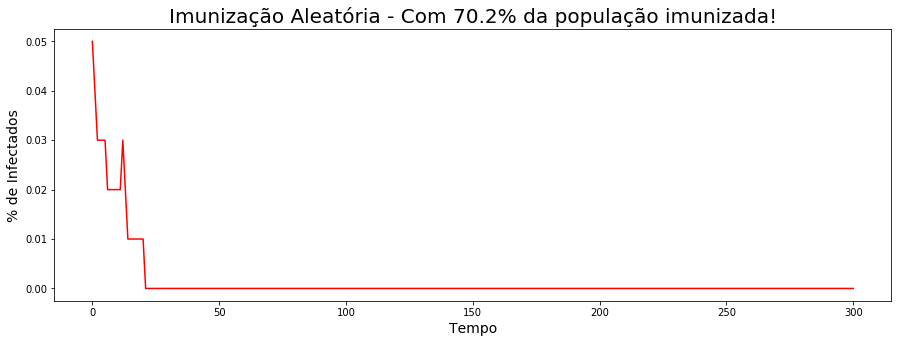

In [52]:
plt.figure(figsize=(15, 5))
plt.title('Imunização Aleatória - Com ' +  str(round(RI_p/N*100,2)) + '% da população imunizada!', fontsize=20)
plt.plot([j/N*100 for j in RI_T], color = "red")
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('% de Infectados', fontsize=14)
plt.show()

#### b. IMUNIZAÇÃO DOS HUBS

Ao imunizar os hubs, estamos fragmentando a rede de contatos, dificultando o alcance do patógeno nos nós de outros componentes. 

Os **hubs** são os resposnsáveis pela grande variação dos graus em uma rede, se imunizarmos os hubs, ou seja, todos os nós com grau maior que $k^{'}_{max}$, vamos diminuir a variância da rede e aumentar o limiar epidêmico $\lambda_c$.

Um vírus pode ser erradicado pelo aumento do **limiar epidêmico**. Então, quanto mais os hubs são imunizados (ou seja, quanto menor o $k^{'}_{max}$), maior é o $\lambda _c$, aumentando a chance que a doença desapareça. A imunização dos hubs muda a rede na qual a doença se espalha, tornando os hubs invisíveis ao patógeno.

$$\lambda_c^{'}\approx \frac{\alpha-2}{3-\alpha}\frac{k_{min}^{2-\alpha}}{(k^{'}_{max})^{\alpha-3}}$$ 

A **taxa de propagação da doença** é dada por: 

$$\lambda =\frac{\beta}{\mu}$$

Portanto, a doença só pode se espalhar se $\lambda>\lambda_c$, em que $\lambda_c$ é o **limiar epidêmico**.

In [46]:
lambda1 = beta/mu
print('A taxa de propagação da doença na rede analisada é ' + str(round(lambda1,2)))

A taxa de propagação da doença na rede analisada é 0.1


Sendo assim, estamos interessado em encontar um $k^{'}_{max}$, tal que $\lambda_c>0.1$. 

In [47]:
kmin = min(dict(G4.degree()).values())
kmax = max(dict(G4.degree()).values())
print('O grau mínimo da rede é: ' + str(kmin))
print('O grau máximo da rede é: ' + str(kmax))

O grau mínimo da rede é: 7
O grau máximo da rede é: 6957


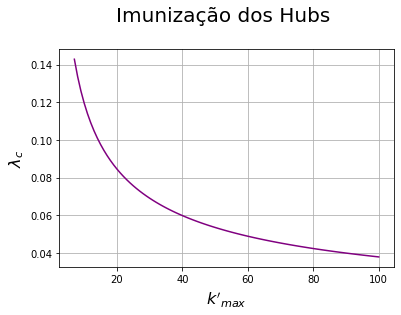

In [48]:
k_list = list(range(kmin,101))
lambda_c = []
for k0 in k_list:
    l_c = ((3-alpha)/(alpha-2))*(k0**(alpha-3))*(kmin**(2-alpha)) #k0 >> kmin
    lambda_c.append(l_c)

plt.plot(k_list,lambda_c, color = "purple")
plt.xlabel("$k'_{max}$", fontsize=16)
plt.ylabel('$\lambda_c$', fontsize=16)
plt.title('Imunização dos Hubs \n', fontsize=20)
plt.grid()
plt.show()

Vamos ver esses resultados por meio de uma simulação.

In [86]:
def SIS_HubsImunization(G, beta, mu, time):
    
    N = len(G.nodes())
    hubs = []
    
    nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'infectado')
    nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'imunizado')
    
    j=1
    sorted_degrees = sorted(list(dict(G.degree()).values()))
    kmax = sorted_degrees[-j]
    degree_dict = dict(G.degree())
    ind_kmax=(list(degree_dict.keys())[list(degree_dict.values()).index(kmax)])
    hubs.append(ind_kmax)
    
    G.node[ind_kmax]['imunizado'] = True
    print('Imunizado Hub: '+ str(ind_kmax) + ' com grau ' + str(kmax))
    
    G, T = SIS(G, beta, mu, time, True)
    print('Infectados: ' + str(T[-1]))
    
    while T[-1]>0:
            
        nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'infectado')
        
        j=j+1
        del degree_dict[ind_kmax]
        kmax = sorted_degrees[-j]
        degree_dict = dict(G.degree())
        ind_kmax = (list(degree_dict.keys())[list(degree_dict.values()).index(kmax)])
        G.node[ind_kmax]['imunizado'] = True
        hubs.append(ind_kmax)
        print('Imunizado Hub: '+ str(ind_kmax) + ' com grau ' + str(kmax))
            
        G, T = SIS(G, beta, mu, time, True)
        print('Infectados: ' + str(T[-1]))
        
    return G, T, hubs

In [87]:
SFG = nx.Graph()
N = 10000
alpha = 2.5
SFG.add_edges_from(ScaleFreeGraph(N, 20, alpha))
time = 100

In [89]:
#(HI_G, HI_T, HI_hubs) = SIS_HubsImunization(SFG, beta, mu, time)

Imunizado Hub: 3 com grau 6923
S = 9999
Infectados: 6743
Imunizado Hub: 2 com grau 3255
S = 9998
Infectados: 6826
Imunizado Hub: 1 com grau 2977
S = 9997
Infectados: 6725
Imunizado Hub: 5 com grau 1418
S = 9996
Infectados: 6743
Imunizado Hub: 7 com grau 1417
S = 9995
Infectados: 6738
Imunizado Hub: 10 com grau 1407
S = 9994
Infectados: 6544
Imunizado Hub: 17 com grau 1238
S = 9993
Infectados: 6585
Imunizado Hub: 6 com grau 1058
S = 9992
Infectados: 6622
Imunizado Hub: 4 com grau 1047
S = 9991
Infectados: 6599
Imunizado Hub: 9 com grau 1044
S = 9990
Infectados: 6541
Imunizado Hub: 13 com grau 1039
S = 9989
Infectados: 6531
Imunizado Hub: 8 com grau 988
S = 9988
Infectados: 6544
Imunizado Hub: 16 com grau 957
S = 9987
Infectados: 6529
Imunizado Hub: 11 com grau 917
S = 9986
Infectados: 6449
Imunizado Hub: 21 com grau 888
S = 9985
Infectados: 6542
Imunizado Hub: 31 com grau 833
S = 9984
Infectados: 6482
Imunizado Hub: 12 com grau 788
S = 9983
Infectados: 6398
Imunizado Hub: 35 com grau 71

In [103]:
#pickle.dump([HI_G, HI_T, HI_hubs], open("Redes/SIS_HubsImunization.p", "wb"))
[HI_G, HI_T, HI_hubs] = pickle.load(open("Redes/SIS_HubsImunization.p", "rb" ))

In [104]:
print('Pela simulação da Imunização Aleatória, encontramos que precisamos imunizar ' + str(len(HI_hubs)) + ' Hubs!')

Pela simulação da Imunização Aleatória, encontramos que precisamos imunizar 107 Hubs!


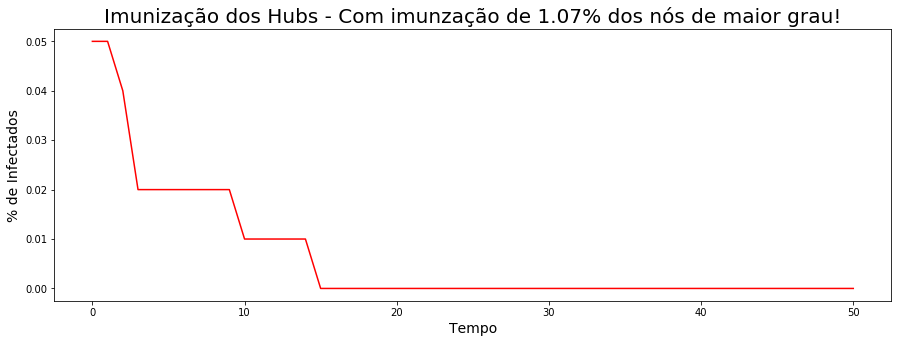

In [105]:
plt.figure(figsize=(15, 5))
plt.title('Imunização dos Hubs - Com imunzação de ' +  str(round(len(HI_hubs)/N*100,2)) + '% dos nós de maior grau!', fontsize=20)
plt.plot([j/N*100 for j in HI_T], color = "red")
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('% de Infectados', fontsize=14)
plt.show()

#### c. IMUNIZAÇÃO DOS VIZINHOS

Em uma rede, é difícil identificar quem são os hubs. No entanto, ainda podemos explorar a topologia de rede para projetar estratégias de imunização mais eficientes. Para isso, contamos com o **paradoxo da amizade**, o fato de que, em média, os vizinhos de um nó têm maior grau do que o próprio nó.

Portanto, ao imunizar os conhecidos de um indivíduo selecionado aleatoriamente, visamos os hubs sem precisar saber com precisão quais indivíduos são hubs.

* Escolha aleatoriamente uma fração $p$ de nós, como fazemos durante a imunização aleatória. Chame esses nós de Grupo 0.

* Selecione aleatoriamente uma aresta para cada nó no Grupo 0. Chamamos de Grupo 1 o conjunto de nós aos quais essas arestas se conectam. 

* Imunize os indivíduos do Grupo 1.

Este algoritmo está implementado na função `selectiveImunization` a seguir.

In [106]:
def selectiveImunization(G):
    nodes = list(G.nodes())
    p = rnd.randint(1, max(nodes)+1)
    group_0 = rnd.sample(nodes, p)
    group_1 = []
    for node in group_0:
        neighbors = list(G.neighbors(node))
        neighbor = rnd.sample(neighbors, 1)
        group_1.append(neighbor[0])
    group_1 = list(set(group_1))
    return group_1

In [107]:
group_1 = selectiveImunization(G4)
gc = round(len(group_1)/N*100,2)
print('Precisamos imunizar um vizinho escolhido aleatoriamente de aproximadamente '+ str(gc) + '% dos vizinhos.')

Precisamos imunizar um vizinho escolhido aleatoriamente de aproximadamente 32.45% dos vizinhos.


In [114]:
def simulation_selectiveImunization(G, time):
    x = list(range(1,time))
    y = []

    for i in x:
        group_1 = selectiveImunization(G)
        y.append(round(len(group_1)/N,2))

    plt.figure(figsize=(15, 5))    
    plt.plot(x,y, color = "purple")
    plt.xlabel("Iterações", fontsize=16)
    plt.ylabel('$g_c$', fontsize=16)
    plt.title('Imunização dos Vizinhos com alpha=2.5 \n Precisamos imunizar em média ' + str(round(np.mean(y)*100,2)) + '% dos nós.', fontsize=20)
    plt.show()

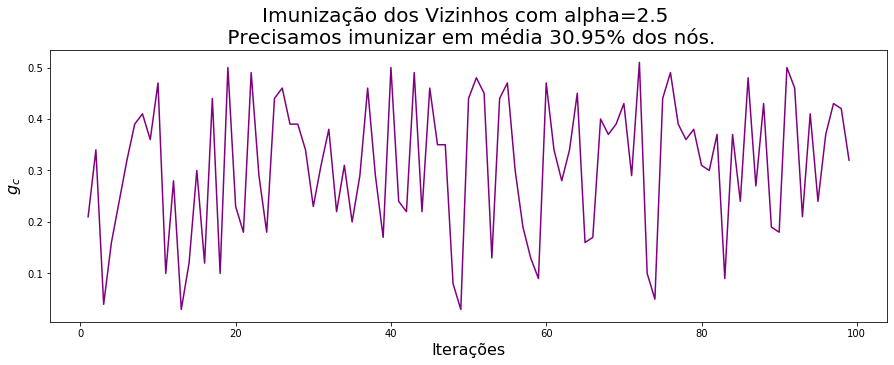

In [115]:
simulation_selectiveImunization(G4,100)

A eficiência dessa estratégia depende apenas de $\alpha$. A imunização seletiva é mais eficiente do que a imunização aleatória, mesmo para $\alpha$ alto, quando os hubs são menos proeminentes.

In [116]:
gcs = []
alphas = list(np.arange(2,3.5,0.25))
N = 10000
k = 20

for alpha in alphas:
    G = nx.Graph()
    G.add_edges_from(ScaleFreeGraph(N, k, alpha))
    g = selectiveImunization(G)
    gc = round(len(g)/N,2)
    gcs.append(gc)
    
pickle.dump([gcs, alphas], open("Redes/selectiveImunization.p", "wb"))
#[gcs, alphas] = pickle.load(open("Redes/selectiveImunization.p", "rb" ))

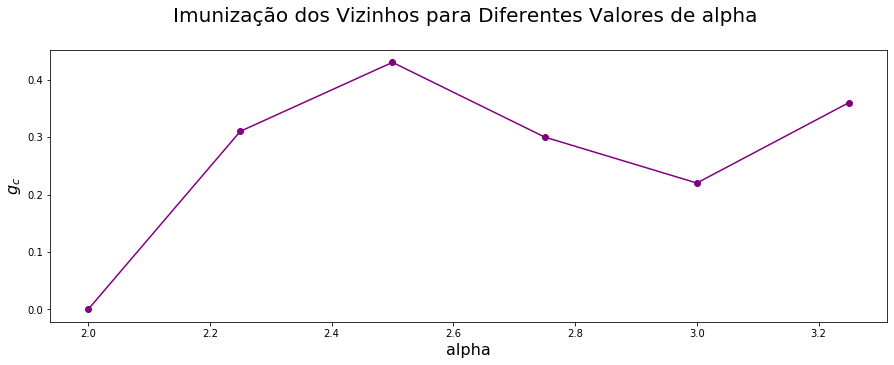

In [117]:
plt.figure(figsize=(15, 5))    
plt.plot(alphas,gcs, marker='o', color = "purple")
plt.xlabel('alpha', fontsize=16)
plt.ylabel('$g_c$', fontsize=16)
plt.title('Imunização dos Vizinhos para Diferentes Valores de alpha \n', fontsize=20)
plt.show()